# Benchmarking Pipeline: Compare Baseline vs DWF Model
This notebook compares a fixed-incentive strategy against the DWF RL model using cancellation rate, incentives, and profitability.

In [1]:
# Load Libraries
import gymnasium as gym
from gymnasium import Env, spaces
import pandas as pd
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import VecNormalize
from scipy.special import expit
import os

In [2]:
train_df = pd.read_csv("datasets/train_split.csv")
val_df =  pd.read_csv("datasets/val_split.csv")

In [3]:
class RideHailingEnv_DWF(Env):
    def __init__(self, df):
        super(RideHailingEnv_DWF, self).__init__()
        self.df = df.reset_index(drop=True)
        self.current_idx = 0
        self.episode_limit = 1000
        self.episode_start = 0

        self.observation_space = spaces.Box(low=0, high=1, shape=(8,), dtype=np.float32)
        self.action_space = spaces.Box(
            low=np.array([-0.15, 0.0]),
            high=np.array([0.15, 5.0]),
            dtype=np.float32
        )

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.current_idx = np.random.randint(0, len(self.df) - self.episode_limit)
        self.episode_start = self.current_idx
        return self._get_observation(), {}

    def step(self, action):
        if self.current_idx >= len(self.df) - 1 or (self.current_idx - self.episode_start >= self.episode_limit):
            obs = self._get_observation()
            done = True
            reward = 0.0
            self.episode_start = self.current_idx + 1
            return obs, reward, done, False, {"CR": 0.5}

        row = self.df.iloc[self.current_idx]
        base_fare = row.get('Base Fare', 10.0)
        t_i = row['Request to Pickup']
        delta = 0.2 * base_fare

        # === Behavior-based features
        rank_percentile = (self.df['Request to Pickup'] < t_i).sum() / len(self.df)
        epsilon = np.random.normal(loc=0.0, scale=0.02)
        RPI = np.clip(1.0 - rank_percentile + epsilon, 0.0, 1.0)

        # Estimate CR *before* action to decide if DWF should intervene
        cr_input_initial = 1.2 * rank_percentile - 1.3 * RPI
        original_CR = 1.0 / (1.0 + np.exp(-cr_input_initial))

        # Default: no intervention
        fare_adjustment, rider_incentive = 0.0, 0.0

        # === Only apply RL action if original CR >= 0.5 ===
        if original_CR >= 0.5:
            fare_adjustment, rider_incentive = np.round(action, 2)

        # DPI based on actual action (whether applied or not)
        action_signal = rider_incentive + abs(fare_adjustment * base_fare)
        DPI = np.clip(1.0 - np.exp(-0.6 * action_signal) + epsilon, 0.0, 1.0)

        # Recalculate CR using full action-aware formula
        cr_input = 1.2 * rank_percentile - 1.3 * RPI - 2.0 * DPI
        CR = 1.0 / (1.0 + np.exp(-cr_input))
        ride_completed = CR < 0.5

        # === Reward and Cost Logic
        base_reward = 1.5 * (1.0 - CR)

        cost = rider_incentive + abs(fare_adjustment) * delta
        cost_ratio = cost / (base_fare + 5)
        cost_penalty = 0.5 * max(cost_ratio - 0.2, 0.0)
        efficiency_bonus = 0.2 if ride_completed and cost_ratio < 0.2 else 0.0

        reward = base_reward - cost_penalty + efficiency_bonus
        reward = np.clip(reward, -2.0, 2.0)

        self.current_idx += 1
        done = False
        obs = self._get_observation()

        return obs, reward, done, False, {
            "CR": CR,
            "RPI": RPI,
            "DPI": DPI,
            "cost": cost,
            "base_reward": base_reward,
            "cost_penalty": cost_penalty,
            "original_CR": original_CR
        }

    def _get_observation(self):
        if self.current_idx >= len(self.df):
            return np.zeros(self.observation_space.shape, dtype=np.float32)
        row = self.df.iloc[self.current_idx]
        return np.array([
            row['Pickup Location'],
            row['Request to Pickup'],
            row['Time of Day'],
            row['Month of Year'],
            row['RPI'],
            row['DPI'],
            row['CR'],
            row['Historical Demand Forecast']
        ], dtype=np.float32)


In [4]:
# Baseline 1 Model
class RideHailingEnv_Feature_Baseline(RideHailingEnv_DWF):
    def __init__(self, df):
        super().__init__(df)
        self.observation_space = spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)
    
    def _get_observation(self):
        row = self.df.iloc[self.current_idx]
        return np.array([
            row['Pickup Location'],
            row['Request to Pickup'],
            row['Time of Day'],
            row['Month of Year'],
        ], dtype=np.float32)
    
    def step(self, action):
        if self.current_idx >= len(self.df) - 1 or (self.current_idx - self.episode_start >= self.episode_limit):
            obs = self._get_observation()
            done = True
            reward = 0.0
            self.episode_start = self.current_idx + 1
            return obs, reward, done, False, {"CR": 0.5}

        row = self.df.iloc[self.current_idx]
        base_fare = row.get('Base Fare', 10.0)
        t_i = row['Request to Pickup']
        delta = 0.2 * base_fare

        # Normalize pickup wait time
        pickup_scaled = t_i / (self.df['Request to Pickup'].max() + 1e-5)

        # Estimate CR using only pickup time
        original_CR = 1.0 / (1.0 + np.exp(-2.5 * (pickup_scaled - 0.5)))

        # Default: no action
        fare_adjustment, rider_incentive = 0.0, 0.0

        # Only intervene if original_CR ≥ 0.5
        if original_CR >= 0.5:
            fare_adjustment, rider_incentive = np.round(action, 2)

        # Recalculate CR after action using same formula
        # Slight tweak to reduce CR if incentive or adjustment applied
        intervention_effect = (rider_incentive + abs(fare_adjustment) * base_fare) / 10.0
        CR = original_CR - 0.3 * intervention_effect
        CR = np.clip(CR, 0.0, 1.0)

        ride_completed = CR < 0.5

        # === Reward logic (same as DWF)
        base_reward = 1.5 * (1.0 - CR)

        cost = rider_incentive + abs(fare_adjustment) * delta
        cost_ratio = cost / (base_fare + 5)
        cost_penalty = 0.5 * max(cost_ratio - 0.2, 0.0)
        efficiency_bonus = 0.2 if ride_completed and cost_ratio < 0.2 else 0.0

        reward = base_reward - cost_penalty + efficiency_bonus
        reward = np.clip(reward, -2.0, 2.0)

        self.current_idx += 1
        done = False
        obs = self._get_observation()

        return obs, reward, done, False, {
            "CR": CR,
            "original_CR": original_CR,
            "cost": cost,
            "base_reward": base_reward,
            "cost_penalty": cost_penalty
        }
  


class RideHailingEnv_Cost_Baseline(RideHailingEnv_DWF):
    def __init__(self, df):
        super().__init__(df)
        self.observation_space = spaces.Box(low=0, high=1, shape=(8,), dtype=np.float32)

    def step(self, action):
        if self.current_idx >= len(self.df) - 1 or (self.current_idx - self.episode_start >= self.episode_limit):
            obs = self._get_observation()
            done = True
            reward = 0.0
            self.episode_start = self.current_idx + 1
            return obs, reward, done, False, {"CR": 0.5}

        row = self.df.iloc[self.current_idx]
        t_i = row['Request to Pickup']
        base_fare = row.get('Base Fare', 10.0)
        delta = 0.2 * base_fare

        # --- Behavioral features
        rank_percentile = (self.df['Request to Pickup'] < t_i).sum() / len(self.df)
        epsilon = np.random.normal(loc=0.0, scale=0.02)
        RPI = np.clip(1.0 - rank_percentile + epsilon, 0.0, 1.0)

        # Estimate CR before applying action
        cr_input_initial = 1.2 * rank_percentile - 1.3 * RPI
        original_CR = 1.0 / (1.0 + np.exp(-cr_input_initial))

        # Apply action only if original CR >= 0.5
        if original_CR >= 0.5:
            fare_adjustment, rider_incentive = np.round(action, 2)
        else:
            fare_adjustment, rider_incentive = 0.0, 0.0

        action_signal = rider_incentive + abs(fare_adjustment * base_fare)
        DPI = np.clip(1.0 - np.exp(-0.6 * action_signal) + epsilon, 0.0, 1.0)

        cr_input = 1.2 * rank_percentile - 1.3 * RPI - 2.0 * DPI
        CR = 1.0 / (1.0 + np.exp(-cr_input))
        ride_completed = CR < 0.5

        reward = 1.0 if ride_completed else -1.0

        self.current_idx += 1
        done = False
        obs = self._get_observation()

        return obs, reward, done, False, {
            "CR": CR,
            "RPI": RPI,
            "DPI": DPI,
            "cost": 0.0,
            "base_reward": reward,
            "cost_penalty": 0.0
        }



class RideHailingEnv_Simple_Baseline(RideHailingEnv_DWF):
    def __init__(self, df):
        super().__init__(df)
        self.observation_space = spaces.Box(low=0, high=1, shape=(8,), dtype=np.float32)

    def step(self, action):
        if self.current_idx >= len(self.df) - 1 or (self.current_idx - self.episode_start >= self.episode_limit):
            obs = self._get_observation()
            done = True
            reward = 0.0
            self.episode_start = self.current_idx + 1
            return obs, reward, done, False, {"CR": 0.5}

        row = self.df.iloc[self.current_idx]
        t_i = row['Request to Pickup']
        base_fare = row.get('Base Fare', 10.0)
        delta = 0.2 * base_fare

        # --- Behavioral features
        rank_percentile = (self.df['Request to Pickup'] < t_i).sum() / len(self.df)
        epsilon = np.random.normal(loc=0.0, scale=0.02)
        RPI = np.clip(1.0 - rank_percentile + epsilon, 0.0, 1.0)

        # Estimate initial CR (before applying action)
        cr_input_initial = 1.2 * rank_percentile - 1.3 * RPI
        original_CR = 1.0 / (1.0 + np.exp(-cr_input_initial))

        # Apply action only if CR ≥ 0.5
        if original_CR >= 0.5:
            fare_adjustment, rider_incentive = np.round(action, 2)
        else:
            fare_adjustment, rider_incentive = 0.0, 0.0

        action_signal = rider_incentive + abs(fare_adjustment * base_fare)
        DPI = np.clip(1.0 - np.exp(-0.6 * action_signal) + epsilon, 0.0, 1.0)

        cr_input = 1.2 * rank_percentile - 1.3 * RPI - 2.0 * DPI
        CR = 1.0 / (1.0 + np.exp(-cr_input))
        ride_completed = CR < 0.5

        # Cost and penalty
        cost = rider_incentive + abs(fare_adjustment) * delta
        static_penalty = -1.0 if cost > 1.5 else 0.0

        reward = 2.0 if ride_completed else -2.0
        reward += static_penalty
        reward = np.clip(reward, -2.0, 1.0)

        self.current_idx += 1
        done = False
        obs = self._get_observation()

        return obs, reward, done, False, {
            "CR": CR,
            "RPI": RPI,
            "DPI": DPI,
            "cost": cost,
            "base_reward": reward,
            "cost_penalty": static_penalty
        }




In [5]:
def train_variant(env_cls, train_df, val_df, model_name):
    # Train environment
    train_env = DummyVecEnv([lambda: env_cls(train_df)])
    train_env = VecNormalize(train_env, norm_obs=True, norm_reward=True)

    model = PPO(
        "MlpPolicy",
        train_env,
        tensorboard_log=f"./ppo_tensorboard_logs/{model_name}/",
        learning_rate=1e-4,
        n_steps=2048,
        batch_size=256,
        gamma=0.98,
        gae_lambda=0.95,
        clip_range=0.4,
        ent_coef=0.01,
        vf_coef=0.8,               # boost critic learning slightly
        max_grad_norm=0.5,
        n_epochs=15,
        policy_kwargs=dict(net_arch=[64, 64]),
        verbose=1,
        device="cuda"
    )

    model.learn(total_timesteps=78000)

    model.save(f"models/{model_name}")
    train_env.save(f"models/{model_name}_vecnormalize.pkl")


In [6]:
# train_variant(RideHailingEnv_Feature_Baseline, train_df, val_df, "model_feature_base")

In [7]:
# train_variant(RideHailingEnv_Cost_Baseline, train_df, val_df, "model_cost_base")

In [8]:
# train_variant(RideHailingEnv_Simple_Baseline, train_df, val_df, "model_simple_base")

Benchmarking

In [9]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.monitor import Monitor
import numpy as np

rider_incentives = []
fare_adjustments = []

def compute_score(avg_cost, avg_cr, alpha=0.6, beta=0.4):
    return alpha * avg_cost + beta * avg_cr

def evaluate_model(model_path, vecnormalize_path, env_class, test_df):
    env = DummyVecEnv([lambda: Monitor(env_class(test_df))])
    vec_norm = VecNormalize.load(vecnormalize_path, env)
    vec_norm.training = False
    vec_norm.norm_reward = False

    model = PPO.load(model_path)

    obs = vec_norm.reset()
    total_cost = 0
    total_intervened = 0
    completed_rides = 0
    total_cr = 0
    retained_from_cancel = 0
    original_cancellations = 0
    num_steps = 0

    while True:
        row = test_df.iloc[num_steps]
        base_fare = row.get("Base Fare", 10.0)
        t_i = row["Request to Pickup"]

        # Estimate original CR before intervention
        rank_percentile = (test_df["Request to Pickup"] < t_i).sum() / len(test_df)
        epsilon = np.random.normal(0, 0.02)
        RPI = np.clip(1.0 - rank_percentile + epsilon, 0.0, 1.0)
        cr_input_initial = 1.2 * rank_percentile - 1.3 * RPI
        original_cr = 1.0 / (1.0 + np.exp(-cr_input_initial))

        originally_cancelled = original_cr >= 0.5
        if originally_cancelled:
            original_cancellations += 1

        # Predict action
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = vec_norm.step(action)
        info = info[0]

        cr = info.get("CR", 0.5)
        is_completed = cr < 0.5

        # Track completions and retained rides
        if is_completed:
            completed_rides += 1
        if originally_cancelled and is_completed:
            retained_from_cancel += 1

        # Only apply cost for interventions
        if original_cr >= 0.5:
            fare_adjustment, rider_incentive = np.round(action[0], 2)
            delta = 0.2 * base_fare
            cost = rider_incentive + abs(fare_adjustment) * delta
            total_cost += cost
            total_intervened += 1

            fare_adjustments.append(fare_adjustment)
            rider_incentives.append(rider_incentive)


        total_cr += cr
        num_steps += 1
        if num_steps >= len(test_df) or done:
            break

    # Metrics
    avg_cr = total_cr / num_steps
    avg_cost = total_cost / total_intervened if total_intervened else 0.0
    avg_cost_per_retained = total_cost / retained_from_cancel if retained_from_cancel else 0.0
    completion_rate = completed_rides / num_steps
    score = compute_score(avg_cost, avg_cr)

    # Breakdown for pie chart
    still_cancelled = original_cancellations - retained_from_cancel
    initially_low_risk = num_steps - original_cancellations

    return {
        "avg_cr": avg_cr,
        "avg_cost": avg_cost,
        "completion_rate": completion_rate,
        "score": score,
        "avg_cost_per_retained": avg_cost_per_retained,
        "retained_from_cancel": retained_from_cancel,
        "still_cancelled": still_cancelled,
        "initially_low_risk": initially_low_risk,
        "original_cancellations": original_cancellations,
        "total_steps": num_steps,
        "fare_adjustments": fare_adjustments,
        "rider_incentives": rider_incentives
    }


In [10]:
test_df = pd.read_csv("datasets/test_split.csv")

In [11]:
results = {}

model_variants = {
    "Baseline PPO": (
        "models/model_feature_base.zip",
        "models/model_feature_base_vecnormalize.pkl",
        RideHailingEnv_Feature_Baseline
    ),
    "DWF": (
        "models/dwf_model_v2.zip",
        "models/dwf_vecnormalize.pkl",
        RideHailingEnv_DWF
    ),
    "Behaviour-Only PPO": (
        "models/model_cost_base.zip",
        "models/model_cost_base_vecnormalize.pkl",
        RideHailingEnv_Cost_Baseline
    ),
    "Simple Cost PPO": (
        "models/model_simple_base.zip",
        "models/model_simple_base_vecnormalize.pkl",
        RideHailingEnv_Cost_Baseline
    ),
}


for name, (model_path, vecnorm_path, env_class) in model_variants.items():
    results[name] = evaluate_model(model_path, vecnorm_path, env_class, test_df)


# Extract metrics
labels = list(results.keys())
avg_costs = [results[k]["avg_cost"] for k in labels]
avg_crs = [results[k]["avg_cr"] for k in labels]
completion_rates = [results[k]["completion_rate"] for k in labels]
scores = [results[k]["score"] for k in labels]
rider_incentive_logs = {k: results[k]["rider_incentives"] for k in labels}
fare_adjustment_logs = {k: results[k]["fare_adjustments"] for k in labels}


c:\anaconda\envs\analysis\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


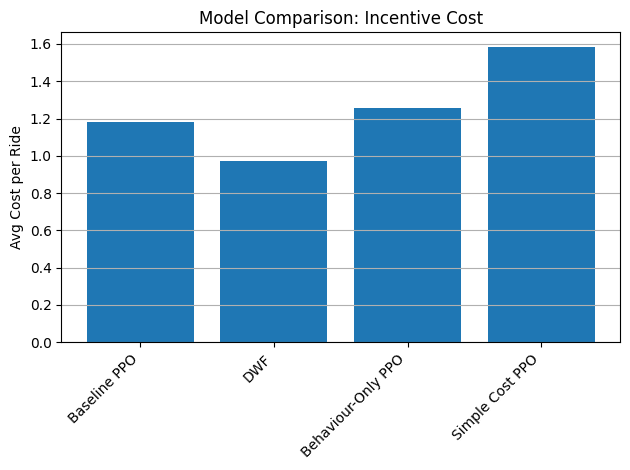

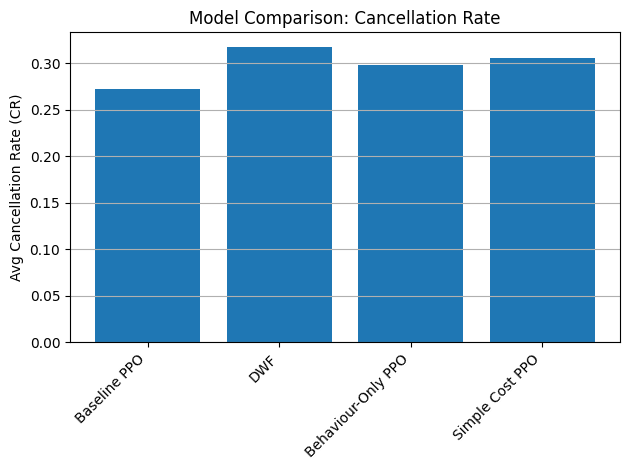

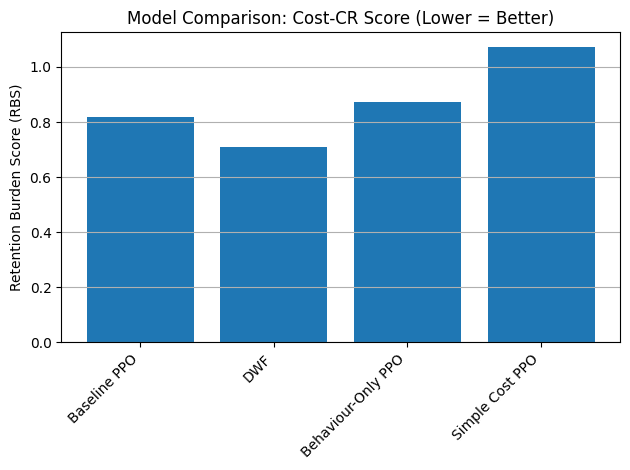

In [12]:
import matplotlib.pyplot as plt

labels = list(results.keys())
avg_costs = [results[k]["avg_cost"] for k in labels]
cancel_rates = [results[k]["avg_cr"] for k in labels]
scores = [results[k]["score"] for k in labels]

# Helper to rotate x-ticks
def plot_bar(data, ylabel, title):
    plt.figure()
    plt.bar(labels, data)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=45, ha='right')  #  rotates labels for clarity
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# Plot 1: Avg Incentive Cost per Ride
plot_bar(avg_costs, "Avg Cost per Ride", "Model Comparison: Incentive Cost")

# Plot 2: Cancellation Rate
plot_bar(cancel_rates, "Avg Cancellation Rate (CR)", "Model Comparison: Cancellation Rate")

# Plot 3: Custom Score
plot_bar(scores, "Retention Burden Score (RBS)", "Model Comparison: Cost-CR Score (Lower = Better)")


In [13]:
import matplotlib.pyplot as plt

def plot_retention_pie(model_name, result):
    labels = ['Retained from Cancellation', 'Still Cancelled', 'Already Low-Risk']
    sizes = [
        result['retained_from_cancel'],
        result['still_cancelled'],
        result['initially_low_risk']
    ]
    colors = ['#2ecc71', '#e74c3c', '#95a5a6']
    
    plt.figure(figsize=(5.5, 5.5))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
    plt.title(f"Ride Retention Breakdown – {model_name}", fontsize=13)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()


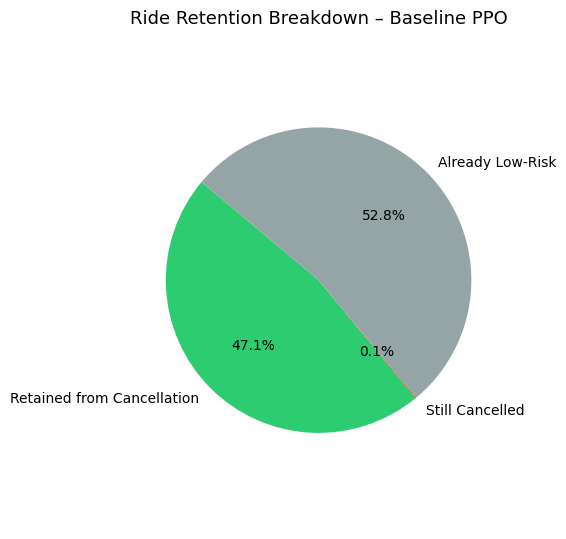

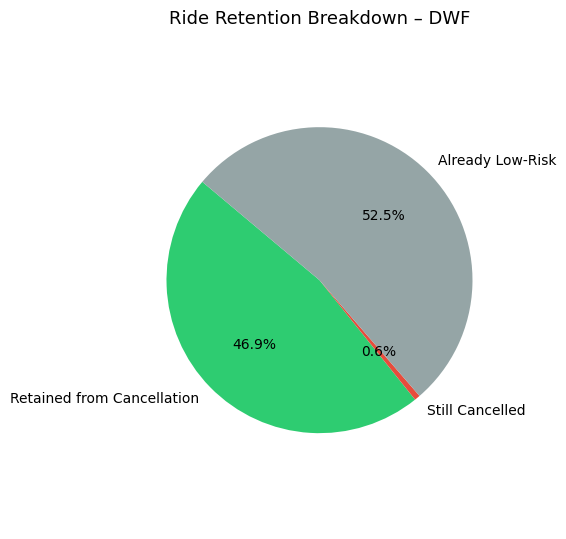

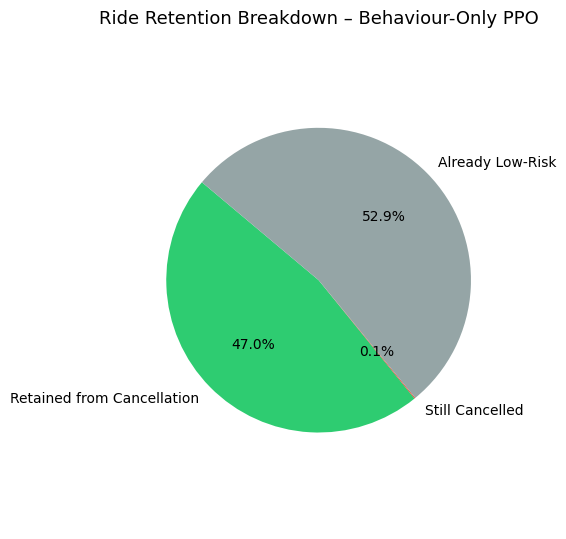

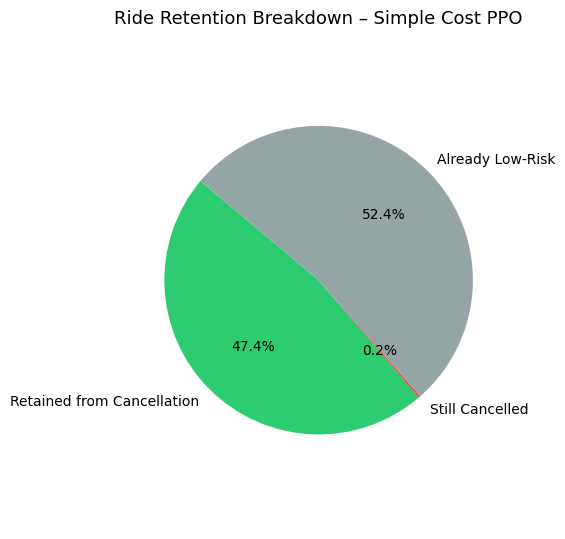

In [14]:
for model_name, result in results.items():
    plot_retention_pie(model_name, result)


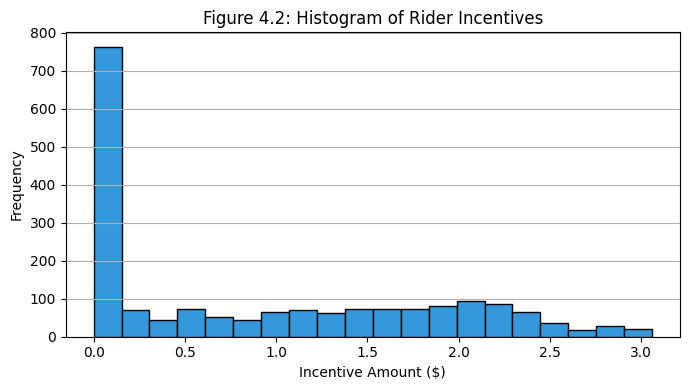

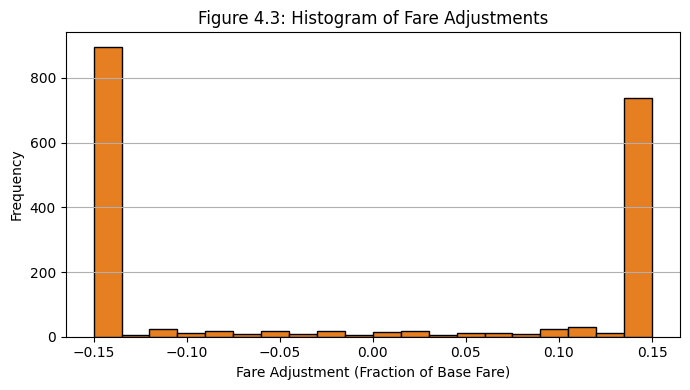

In [15]:
import matplotlib.pyplot as plt

# Get action logs from your result dictionary
incentives = results["DWF"]["rider_incentives"]
fare_adjs = results["DWF"]["fare_adjustments"]

# Figure 4.2: Histogram of Rider Incentives
plt.figure(figsize=(7, 4))
plt.hist(incentives, bins=20, color="#3498db", edgecolor='black')
plt.title("Figure 4.2: Histogram of Rider Incentives")
plt.xlabel("Incentive Amount ($)")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Figure 4.3: Histogram of Fare Adjustments
plt.figure(figsize=(7, 4))
plt.hist(fare_adjs, bins=20, color="#e67e22", edgecolor='black')
plt.title("Figure 4.3: Histogram of Fare Adjustments")
plt.xlabel("Fare Adjustment (Fraction of Base Fare)")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


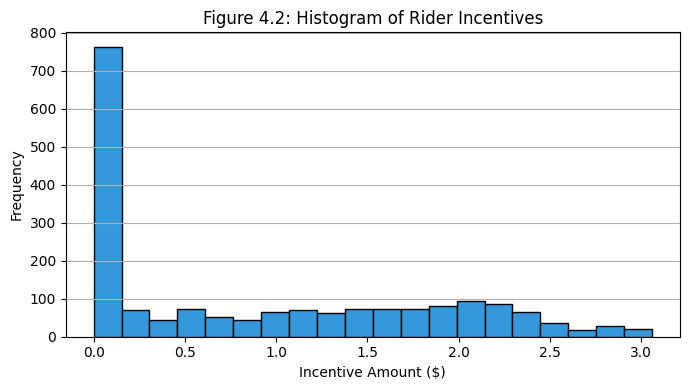

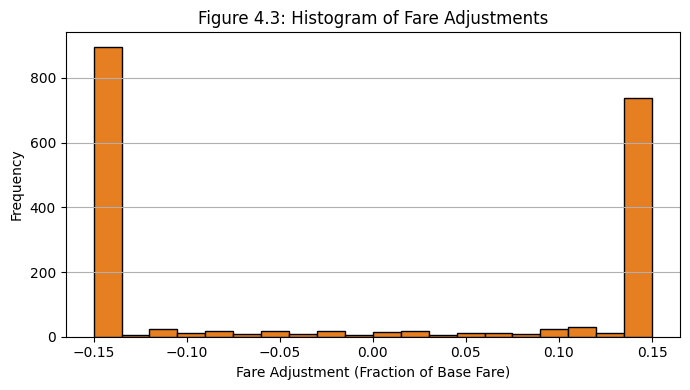

In [16]:
import matplotlib.pyplot as plt

# Get action logs from your result dictionary
incentives = results["Baseline PPO"]["rider_incentives"]
fare_adjs = results["Baseline PPO"]["fare_adjustments"]

# Figure 4.2: Histogram of Rider Incentives
plt.figure(figsize=(7, 4))
plt.hist(incentives, bins=20, color="#3498db", edgecolor='black')
plt.title("Figure 4.2: Histogram of Rider Incentives")
plt.xlabel("Incentive Amount ($)")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Figure 4.3: Histogram of Fare Adjustments
plt.figure(figsize=(7, 4))
plt.hist(fare_adjs, bins=20, color="#e67e22", edgecolor='black')
plt.title("Figure 4.3: Histogram of Fare Adjustments")
plt.xlabel("Fare Adjustment (Fraction of Base Fare)")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Hypothesis Test